#  Taller 5: Clasificación no supervisada de imágenes multibanda con K-Means

  **Universidad Nacional de Colombia**  
*Facultad de Ciencias Agrarias*  
*Maestria en Geomática*  
*Geoprocesamiento*  

**presentado por** Jeanneth Perez Vallejo 

## Clasificacion NO supervisada mediante algoritmo k-means y calculo de metricas 

Es un método de análisis de datos donde un algoritmo agrupa automáticamente elementos (como píxeles en imágenes) en clases basadas en sus características, sin la intervención o conocimiento previo del usuario sobre las clases deseadas. Esencialmente, el algoritmo identifica patrones y similitudes en los datos y los agrupa en clústeres, sin requerir muestras de entrenamiento o etiquetas predefinidas. 

K-means es un algoritmo de clasificación no supervisada (clusterización) que agrupa objetos en k grupos basándose en sus características. El agrupamiento se realiza minimizando la suma de distancias entre cada objeto y el centroide de su grupo o cluster. Se suele usar la distancia cuadrática. Con el propósito de identificar patrones entre estos, pero esas observaciones deben ser diferentes a los otros grupos. Teniendo en cuenta lo anterior, se puede decir que el método K-means busca maximizar la variación inter-cluster (entre los k grupos formados) y minimizar la variación intra-cluster (entre las observaciones que se encuentran dentro de cada grupo).


### Se selecciona como zona de estudio el Parque Nacional Natural Tinigua La Macarena Meta

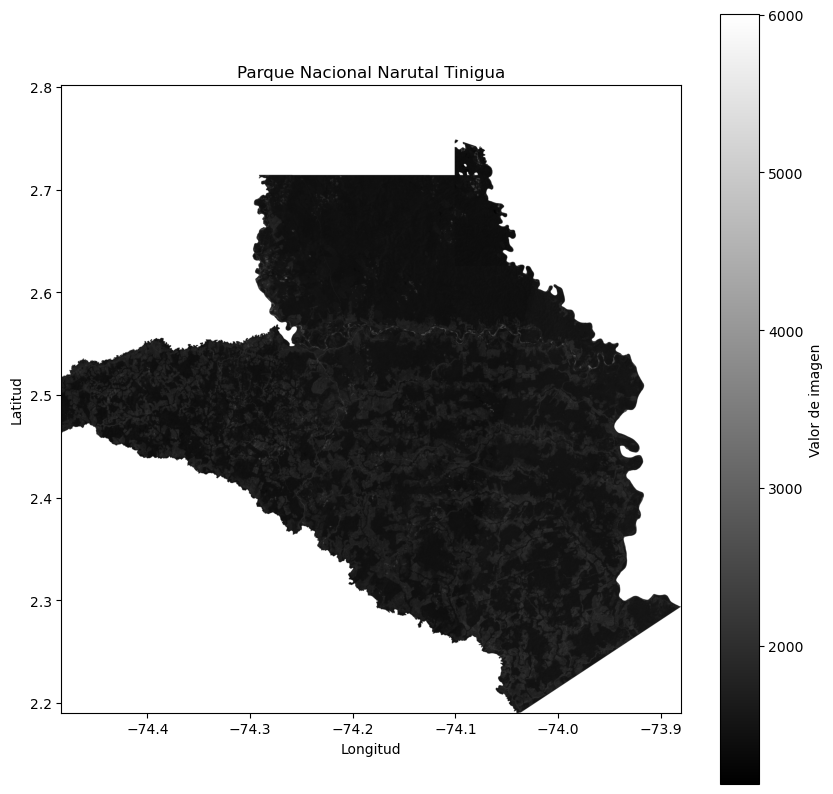

In [4]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd

# Ruta a tu imagen raster y shapefile
ruta_raster = "/root/Geoprocesamiento_talleres-1/geo_data/tinigua_sentinel2_drive.tif"

# Cargar la imagen raster (usa la banda que prefieras para fondo, ejemplo: banda 1)
with rasterio.open(ruta_raster) as src:
    img = src.read(2)  # puedes cambiar el número de banda
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    crs_raster = src.crs





# Visualizar
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(img, cmap='gray', extent=extent)
#muestras.plot(ax=ax, column='Clase', cmap='tab10', markersize=30, legend=True)
plt.title("Parque Nacional Natural Tinigua")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.colorbar(im, ax=ax, label="Valor de imagen")
plt.show()

#### Se selecciona una ventana de trabajo 

Shape del array seleccionado: (4, 700, 700)


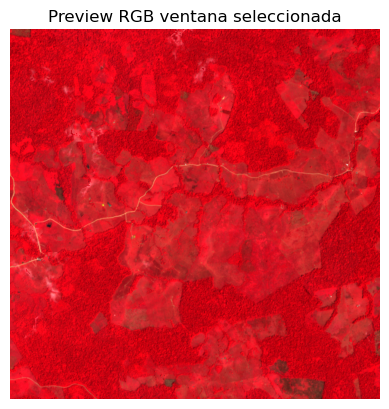

Recorte guardado en: /root/Geoprocesamiento_talleres-1/geo_data/tinigua_crop_700x700.tif


In [3]:

import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np

# Ruta de la imagen original
raster_path = "/root/Geoprocesamiento_talleres-1/geo_data/tinigua_sentinel2_drive.tif"

# Tamaño de la ventana
rows, cols = 700, 700

with rasterio.open(raster_path) as src:
    H, W = src.height, src.width
    # Ventana centrada
    win = Window((W - cols)//2, (H - rows)//2, cols, rows)
    img = src.read(window=win)  # (bands, rows, cols)
    profile = src.profile

print("Shape del array seleccionado:", img.shape)

# Visualiza una composición RGB (ajusta bandas según tu raster)
rgb = np.stack([img[3], img[2], img[1]], axis=-1) # Sentinel-2: bandas 4,3,2 (0-based)
lo, hi = np.percentile(rgb, [1, 99])
rgb_stretch = np.clip((rgb - lo) / (hi - lo), 0, 1)
plt.imshow(rgb_stretch)
plt.axis("off")
plt.title("Preview RGB ventana seleccionada")
plt.show()

print(f"Recorte guardado en: {subset_path}")

## 2. Aplicacion de  la segmentación no supervisada utilizando el algoritmo K-Means.  
   - Elija un número apropiado de conglomerados (*k*) y justifique su elección utilizando las puntuaciones de inercia y silueta.  
   - Visualice e interprete la distribución espacial de los clusters resultantes.  

In [9]:

import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [7]:
raster_path = "/root/Geoprocesamiento_talleres-1/geo_data/tinigua_sentinel2_drive.tif"
subset_path = "/root/Geoprocesamiento_talleres-1/geo_data/tinigua_crop_700x700.tif"
rows, cols = 700, 700

with rasterio.open(raster_path) as src:
    H, W = src.height, src.width
    win = Window((W - cols)//2, (H - rows)//2, cols, rows)
    subset = src.read(window=win)
    meta = src.meta.copy()
    meta.update({
        "height": rows,
        "width": cols,
        "transform": src.window_transform(win),
        "compress": "lzw",
        "tiled": True
    })

with rasterio.open(subset_path, "w", **meta) as dst:
    dst.write(subset)

# === 2. Clase ClusteredStack (idéntica al notebook) ===
class ClusteredStack:
    def __init__(self, raster_path):
        self.raster_path = raster_path
        self.model_input = None
        self.height = self.width = self.depth = 0
        self.k_range = []
        self.models = []
        self.predicted_rasters = []
        self.inertia_scores = []
        self.silhouette_scores = []

    def set_raster_stack(self):
        with rasterio.open(self.raster_path) as src:
            stack = src.read()
            stack = np.nan_to_num(stack)
            self.depth, self.height, self.width = stack.shape
            self.model_input = stack.reshape(self.depth, -1).T

    def build_models(self, k_values):
        self.k_range = list(k_values)
        self.models, self.predicted_rasters = [], []
        self.inertia_scores, self.silhouette_scores = [], []
        for k in self.k_range:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = km.fit_predict(self.model_input)
            self.models.append(km)
            self.inertia_scores.append(km.inertia_)
            self.silhouette_scores.append(
                silhouette_score(self.model_input, labels, sample_size=1000)
            )
            self.predicted_rasters.append(labels.reshape(self.height, self.width))

    def show_clustered(self, cmap="Accent"):
        for k, img_cls in zip(self.k_range, self.predicted_rasters):
            plt.figure(figsize=(5, 5))
            plt.imshow(img_cls, cmap=cmap)
            plt.title(f"{k} clusters")
            plt.axis("off")
            plt.colorbar()
            plt.show()

    def show_inertia(self):
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.inertia_scores, "o-")
        plt.xlabel("número de clusters (k)")
        plt.ylabel("Inercia")
        plt.title("Elbow method")
        plt.show()

    def show_silhouette(self):
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.silhouette_scores, "o-")
        plt.xlabel("número de clusters (k)")
        plt.ylabel("Silhouette")
        plt.title("Silhouette scores")
        plt.show()

## Visualización de la distribución espacial de los clusters resultantes.  

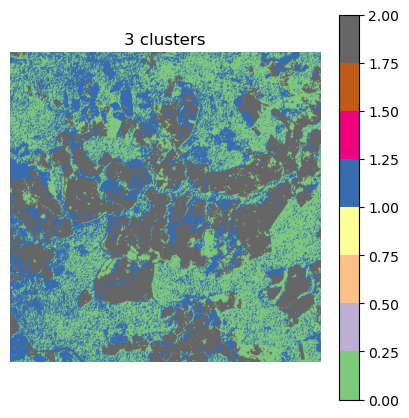

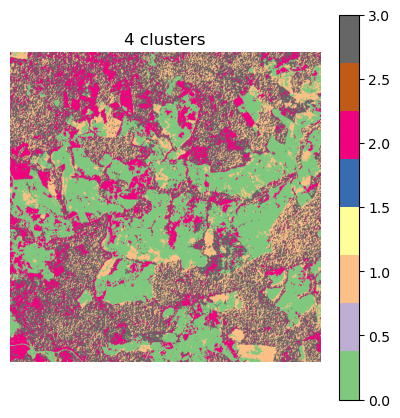

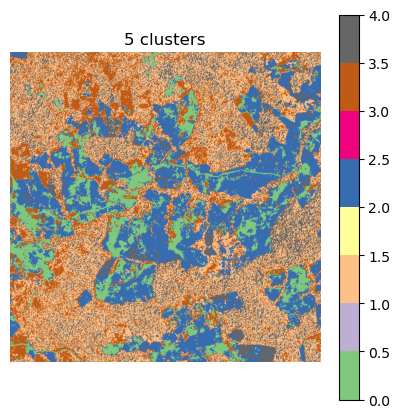

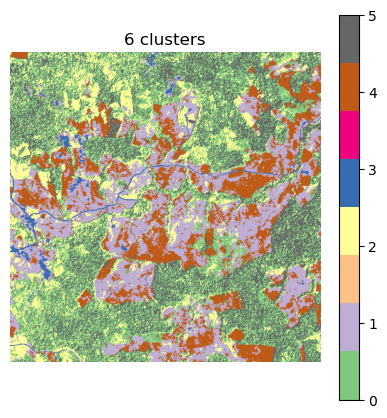

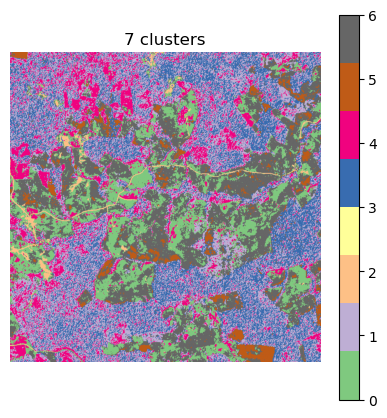

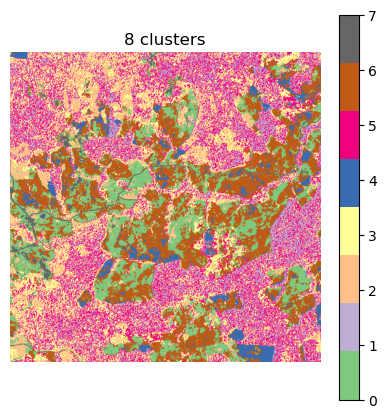

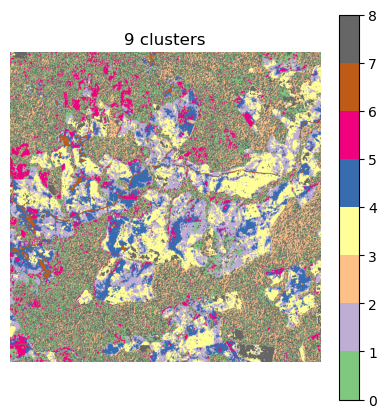

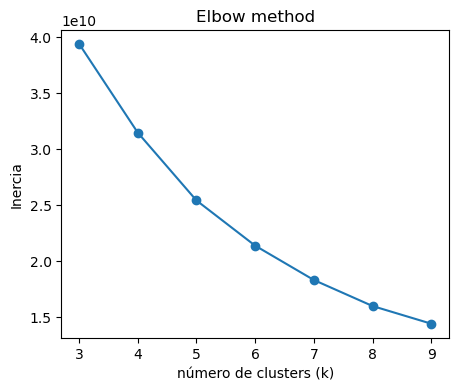

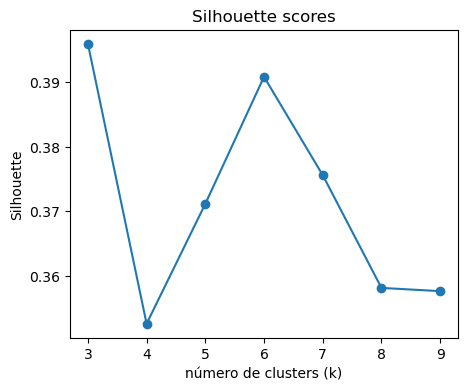

In [ ]:
clustered_models = ClusteredStack(subset_path)
# Prepara la matriz de pixeles x bandas
clustered_models.set_raster_stack()
# Define el rango de k a probar
ks = np.arange(3, 10)
# Entrena y evalúa modelos para cada k
clustered_models.build_models(ks)

# GRAFICA los resultados (como en el notebook)
clustered_models.show_clustered()
clustered_models.show_inertia()
clustered_models.show_silhouette()


## ¿Por qué es útil el  Silhouette coefficient?
El silhouette_score mide qué tan bien separados o cercanos están los clusters encontrados.

Cerca de 1: Clusters bien definidos, compactos y separados.

Cerca de 0: Clusters con solapamiento, poco definidos.
Negativo: Algunos puntos estarían mejor en otro cluster = mala segmentación.
¿Por qué usarlo junto con la Elbow method?

El metodo Elbow  (inercia) solo te dice cuándo dejar de aumentar k porque la mejora se vuelve marginal, pero no te dice si tus clusters son realmente buenos.
El índice de silueta te ayuda a ver si los clusters que aparecen tienen sentido estructural y están bien formados.

En este caso usaremos el método de clustering, que consiste en la agrupación automática de datos. Al ser un aprendizaje no-supervisado, no hay una respuesta correcta. Esto hace que la evaluación de los grupos identificados sea un poco subjetiva.

Revisando las graficas se selecciona el K = 3.

In [ ]:
# MIRA LAS GRÁFICAS:
# - El "codo" en la curva de inercia indica el k donde la reducción de inercia se estabiliza.
# - La silueta debe ser razonablemente alta.
# Elige tu k óptimo 
ks = np.arange(3, 10) 
k_opt = 3
idx = ks.tolist().index(k_opt)
cluster_band = clustered_models.predicted_rasters[idx][np.newaxis, :, :]

## incorporación del K seleccionado  como una variable categórica

In [17]:
# ========== 5. AGREGA EL CLUSTER MAP COMO BANDA CATEGÓRICA ==========

with rasterio.open(subset_path) as src:
    stack = src.read()  # (bandas, rows, cols)

stack_final = np.concatenate([stack, cluster_band], axis=0)  # (bandas+1, rows, cols)
meta_out = meta.copy()
meta_out.update(count=stack_final.shape[0])
with rasterio.open("/root/Geoprocesamiento_talleres-1/geo_data/tinigua_stack_kmeans.tif", "w", **meta_out) as dst:
    dst.write(stack_final)

print("Stack final con banda de clusters guardado como tinigua_stack_kmeans.tif")


Stack final con banda de clusters guardado como tinigua_stack_kmeans.tif


#### Conformación numero de bandas stack con variable categorica añadida

In [14]:
with rasterio.open("/root/Geoprocesamiento_talleres-1/geo_data/tinigua_crop_700x700.tif") as src:
    print("Bandas del recorte original:", src.count)

Bandas del recorte original: 4


In [16]:
import rasterio

with rasterio.open("/root/Geoprocesamiento_talleres-1/geo_data/tinigua_stack_kmeans.tif") as src:
    print("Número de bandas:", src.count)  # <-- Esto te da el número de bandas
    print("Shape de las bandas:", src.read().shape)  # (num_bandas, rows, cols)

Número de bandas: 5
Shape de las bandas: (5, 700, 700)


In [24]:
stack_kmeans_path = "/root/Geoprocesamiento_talleres-1/geo_data/tinigua_stack_kmeans.tif"
with rasterio.open(stack_kmeans_path) as src:
    stack = src.read()  # (n_bandas, rows, cols)
    profile = src.profile

n_bandas, rows, cols = stack.shape
print("Stack shape (bandas, rows, cols):", stack.shape)

Stack shape (bandas, rows, cols): (5, 700, 700)


## Clasificación no supervisada y metricas 

In [25]:
# ========== 2. PREPARA LA MATRIZ DE DATOS PARA CLUSTERING ==========

# --- a) Con banda de clusters como variable categórica (simplemente la última banda) ---
X_cat = stack.reshape(n_bandas, -1).T  # (n_pixeles, n_bandas)
print("X_cat shape (con banda de clusters):", X_cat.shape)

# --- b) Con variables dummies para la banda de clusters ---
cluster_vals = X_cat[:, -1].astype(int)
k_opt = np.max(cluster_vals) + 1
dummies = np.eye(k_opt)[cluster_vals]  # (n_pixeles, k_opt)

X_dummy = np.hstack([X_cat[:, :-1], dummies])
print("X_dummy shape (bandas originales + dummies):", X_dummy.shape)

X_cat shape (con banda de clusters): (490000, 5)
X_dummy shape (bandas originales + dummies): (490000, 7)


## Metricas para clasificación No supervisada 

In [ ]:
# ========== 3. CLASIFICACIÓN NO SUPERVISADA CON KMEANS Y MÉTRICAS ==========

def kmeans_clustering(X, n_clusters, label_prefix=""):
    print(f"\n--- KMeans clustering: {label_prefix} ---")
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertia = km.inertia_
    # Para silhouette, samplea si hay muchos pixeles
    n_sample = min(10000, len(X))
    silhouette = silhouette_score(X, labels, sample_size=n_sample, random_state=42)
    print(f"Inercia: {inertia:.2f}")
    print(f"Silhouette: {silhouette:.3f}")
    return labels

# Define número de clusters para esta nueva clasificación (puedes ajustar)
n_clusters_final = 4

# --- a) Clustering usando banda de clusters como variable categórica ---
labels_cat = kmeans_clustering(X_cat, n_clusters=n_clusters_final, label_prefix="Categórica")
labels_cat_img = labels_cat.reshape(rows, cols)





--- KMeans clustering: Categórica ---
Inercia: 31455351209.46
Silhouette: 0.362

--- KMeans clustering: Dummies ---
Inercia: 31455149327.99
Silhouette: 0.362


In [ ]:

profile_out = profile.copy()
profile_out.update(dtype="uint8", count=1)
with rasterio.open("/root/Geoprocesamiento_talleres-1/geo_data/cluster_kmeans_cat.tif", "w", **profile_out) as dst:
    dst.write(labels_cat_img.astype(np.uint8), 1)
with rasterio.open("/root/Geoprocesamiento_talleres-1/geo_data/cluster_kmeans_dummy.tif", "w", **profile_out) as dst:
    dst.write(labels_dummy_img.astype(np.uint8), 1)

print("Mapas de clusters guardados como cluster_kmeans_cat.tif y cluster_kmeans_dummy.tif")

Mapas de clusters guardados como cluster_kmeans_cat.tif y cluster_kmeans_dummy.tif


## Visualización de la clasificación.

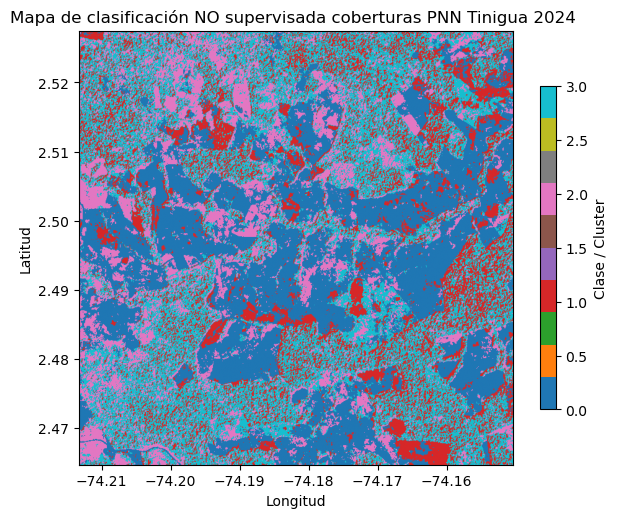

In [31]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# ==== 1. Ruta del raster de clasificación ====
ruta_mapa = "/root/Geoprocesamiento_talleres-1/geo_data/cluster_kmeans_cat.tif"  # Cambia por tu ruta

# ==== 2. Lee el raster y el perfil ====
with rasterio.open(ruta_mapa) as src:
    mapa_pred = src.read(1)
    transform = src.transform

# ==== 3. Calcula las coordenadas de los bordes ====
# Esquinas del raster en coordenadas geográficas
rows, cols = mapa_pred.shape
left, top = transform * (0, 0)
right, bottom = transform * (cols, rows)

# ==== 4. Visualiza el mapa con coordenadas ====
plt.figure(figsize=(7, 6))
cmap = "tab10"  # O el que prefieras

extent = [left, right, bottom, top]  # Ojo: en imshow es [xmin, xmax, ymin, ymax]
img = plt.imshow(mapa_pred, cmap=cmap, extent=extent, origin="upper")
plt.title("Mapa de clasificación NO supervisada coberturas PNN Tinigua 2024 ")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.colorbar(img, shrink=0.7, label="Clase / Cluster")
plt.show()

Nota: Las metricas de la clasificacion supervisada no se pueden calcular para este algoritmo.